In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

import lightgbm as lgb

%matplotlib inline

# Load Data

In [2]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')
print('Train:\t', train.shape)
print('Test: \t', test.shape)

Train:	 (307506, 172)
Test: 	 (48744, 171)


In [3]:
# define categorical features
cat_feature = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
               'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
               'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
               'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 
               'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
               'Binary_CREDIT_DAY_OVERDUE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 
               'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
               'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',  
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
               'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 
               'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
               'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
               'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
               'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
               'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',  'FLAG_DOCUMENT_20', 
               'FLAG_DOCUMENT_21', ]

dis_feature = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 
               'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'Total_BUREAU', 'Closed_BUREAU', 'Active_BUREAU', 'Sold_BUREAU', 
               'Bad_BUREAU', 'Count_AMT_CREDIT_MAX_OVERDUE', 'Credit_CREDIT_TYPE', 
               'Loan_CREDIT_TYPE', 'Count_POS_CASH', 'Completed_CASH_CONTRACT', 
               'Other_CASH_CONTRACT', 'Count_Credit_Card', 'Active_Credit_CONTRACT', 
               'Completed_Credit_CONTRACT', 'Other_Credit_CONTRACT', 'Count_installment', 
               'Count_prev', 'Count_prev_Cash_loan', 'Count_prev_Consumer_loan', 
               'Count_prev_Revolving_loan', 'Count_Y_prev_FLAG_LAST_APPL_PER_CONTRACT', 
               'Count_N_prev_FLAG_LAST_APPL_PER_CONTRACT', 'Count_1_prev_NFLAG_LAST_APPL_IN_DAY', 
               'Count_0_prev_NFLAG_LAST_APPL_IN_DAY', 'Count_Approved_prev_NAME_CONTRACT_STATUS', 
               'Count_Canceled_prev_NAME_CONTRACT_STATUS', 'Count_Refused_prev_NAME_CONTRACT_STATUS', 
               'Count_Unused_prev_NAME_CONTRACT_STATUS',  'Count_Cash_prev_NAME_PAYMENT_TYPE',
               'Count_XNA_prev_NAME_PAYMENT_TYPE', 'Count_Noncash_prev_NAME_PAYMENT_TYPE', 
               'Count_Unaccompanied_prev_NAME_TYPE_SUITE', 'Count_Accompanied_prev_NAME_TYPE_SUITE', 
               'Count_Other_NAME_TYPE_SUITE', 'Count_Repeater_prev_NAME_CLIENT_TYPE', 
               'Count_New_prev_NAME_CLIENT_TYPE', 'Count_Refreshed_prev_NAME_CLIENT_TYPE', 
               'Count_POS_prev_NAME_PORTFOLIO', 'Count_Cash_prev_NAME_PORTFOLIO', 
               'Count_Cards_prev_NAME_PORTFOLIO', 'Count_Other_prev_NAME_PORTFOLIO', 
               'Count_XNA_prev_NAME_PRODUCT_TYPE', 'Count_xsell_prev_NAME_PRODUCT_TYPE', 
               'Count_walkin_prev_NAME_PRODUCT_TYPE', 'Count_0_prev_NFLAG_INSURED_ON_APPROVAL', 
               'Count_1_prev_NFLAG_INSURED_ON_APPROVAL']

con_feature = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
               'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 
               'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'Sum_CASH_MONTH_BALANCE', 
               'Mean_CASH_MONTH_BALANCE', 'Median_CASH_MONTH_BALANCE', 'Sum_CASH_CNT_INSTALMENT', 
               'Mean_CASH_CNT_INSTALMENT', 'Median_CASH_CNT_INSTALMENT', 
               'Sum_CASH_CNT_INSTALMENT_FUTURE', 'Mean_CASH_CNT_INSTALMENT_FUTURE', 
               'Median_CASH_CNT_INSTALMENT_FUTURE', 'Active_CASH_CONTRACT', 
               'Sum_CASH_SK_DPD', 'Mean_CASH_SK_DPD', 'Median_CASH_SK_DPD', 'Sum_CASH_SK_DPD_DEF', 
               'Mean_CASH_SK_DPD_DEF', 'Median_CASH_SK_DPD_DEF', 'Sum_NUM_INSTALMENT_VERSION', 
               'Mean_NUM_INSTALMENT_VERSION', 'Median_NUM_INSTALMENT_VERSION', 
               'Sum_NUM_INSTALMENT_NUMBER', 'Mean_NUM_INSTALMENT_NUMBER', 
               'Median_NUM_INSTALMENT_NUMBER', 'Sum_DAYS_INSTALMENT', 'Mean_DAYS_INSTALMENT',
               'Median_DAYS_INSTALMENT', 'Sum_DAYS_ENTRY_PAYMENT', 'Mean_DAYS_ENTRY_PAYMENT', 
               'Median_DAYS_ENTRY_PAYMENT', 'Sum_AMT_INSTALMENT', 'Mean_AMT_INSTALMENT', 
               'Median_AMT_INSTALMENT', 'Sum_AMT_PAYMENT', 'Mean_AMT_PAYMENT', 'Median_AMT_PAYMENT',
               'Sum_prev_AMT_ANNUITY', 'Mean_prev_AMT_ANNUITY', 'Median_prev_AMT_ANNUITY', 
               'Sum_prev_AMT_APPLICATION', 'Mean_prev_AMT_APPLICATION', 'Median_prev_AMT_APPLICATION', 
               'Sum_prev_AMT_CREDIT', 'Mean_prev_AMT_CREDIT', 'Median_prev_AMT_CREDIT', 
               'Sum_prev_AMT_DOWN_PAYMENT', 'Sum_prev_AMT_GOODS_PRICE',  'Mean_prev_AMT_GOODS_PRICE', 
               'Median_prev_AMT_GOODS_PRICE', 'Sum_prev_RATE_DOWN_PAYMENT', 'Sum_prev_DAYS_DECISION', 
               'Mean_prev_DAYS_DECISION', 'Median_prev_DAYS_DECISION','Sum_prev_CNT_PAYMENT', 
               'Mean_prev_CNT_PAYMENT', 'Median_prev_CNT_PAYMENT']

features = cat_feature + dis_feature + con_feature

# define numerical and categorical features
print('Categorical:\t', len(cat_feature))
print('Discrete:\t', len(dis_feature))
print('Continuous:\t', len(con_feature))
print('Total:\t\t', len(features))

Categorical:	 49
Discrete:	 55
Continuous:	 66
Total:		 170


# Logistic Regression

In [4]:
# # Initialize H2O cluster
# h2o.init(nthreads=-1, max_mem_size='45G')
# h2o.remove_all()

# # Transform to H2O Frame, and make sure the target variable is categorical
# h2o_train = H2OFrame(train[features + ['TARGET']])
# h2o_test = H2OFrame(test[features])

# # transform into categorical
# h2o_train['TARGET'] = h2o_train['TARGET'].asfactor()

# for name in cat_feature:
#     h2o_train[name] = h2o_train[name].asfactor()
#     h2o_test[name] = h2o_test[name].asfactor()

In [5]:
# # Train logistic regression model with Lasso using grid search
# hyper_parameters = {'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
#                     'lambda': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

# # Create GLM model
# glm = H2OGeneralizedLinearEstimator(family='binomial', balance_classes=True, 
#                                     early_stopping=True, custom_metric_func='auc',
#                                     keep_cross_validation_predictions=True, nfolds=5)

# # Grid search
# glm_grid = H2OGridSearch(glm, hyper_parameters, grid_id='GLM')
# glm_grid.train(x=features, y='TARGET', training_frame=h2o_train)

In [6]:
# # Get the grid search result, sorted by AUC
# glm_models = glm_grid.get_grid(sort_by='auc', decreasing=True)

# # Choose the best model
# best_glm = glm_grid.models[0]

# glm_models

In [7]:
# # Make predictions
# glm_train_pred = best_glm.predict(h2o_train).as_data_frame()['p1'].values
# glm_test_pred = best_glm.predict(h2o_test).as_data_frame()['p1'].values

# # Build the ROC curve
# glm_fpr, glm_tpr, _ = roc_curve(train['TARGET'].values, glm_train_pred)
# glm_auc = np.round(auc(glm_fpr, glm_tpr), 3)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(glm_fpr, glm_tpr, label='AUC: ' + str(glm_auc))
# ax.plot(glm_fpr, glm_fpr, 'k:')
# ax.set_xlabel('False Positive Rate', fontsize=12)
# ax.set_ylabel('True Positive Rate', fontsize=12)
# ax.legend(fontsize=12)
# plt.show()

In [8]:
# # make prediction file
# test_id = test['SK_ID_CURR'].values
# test_pred = glm_test_pred

# glm_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
#                        columns=['SK_ID_CURR', 'TARGET'])
# glm_csv.to_csv('./result/all_feature_h2o_logistic_regression_balanced.csv', index=False)

# # Shutdown h2o instance
# h2o.cluster().shutdown()

# LigthGBM Data Preparation

In [9]:
# encoding categorical data into numerical format
label_encoders = []
for name in cat_feature:
    encoder = LabelEncoder()
    train[name] = encoder.fit_transform(train[name])
    test[name] = encoder.transform(test[name])
    label_encoders.append(encoder)

In [10]:
# create LightGBM dataset
train_x = train[features]
train_y = train['TARGET'].values

gbm_train = lgb.Dataset(data=train_x, label=train_y, feature_name=features, 
                        categorical_feature=cat_feature, free_raw_data=False)

# LightGBM Random Forest

In [21]:
# Cross validation
params = {'objective': 'binary', 
          'boosting': 'rf', 
          'num_leaves': 31, 
          'num_threads': 4, 
          'max_depth': -1, 
          'min_data_in_leaf': 20, 
          'bagging_fraction': 0.632, 
          'bagging_freq': 1, 
          'feature_fraction': 0.5, 
          'lambda_l1': 0.0,
          'lambda_l2': 0.0,
          'drop_rate': 0.1, 
          'is_unbalance': True, 
          'metric': ['auc']}

# 5-folder cross validation (no early stopping)
history = lgb.cv(params, train_set=gbm_train, num_boost_round=1000, nfold=5, 
                 stratified=True, early_stopping_rounds=0, verbose_eval=False, 
                 seed=42, feature_name=features, categorical_feature=cat_feature)

Best rounds:  8 	Best AUC:  0.735188140275


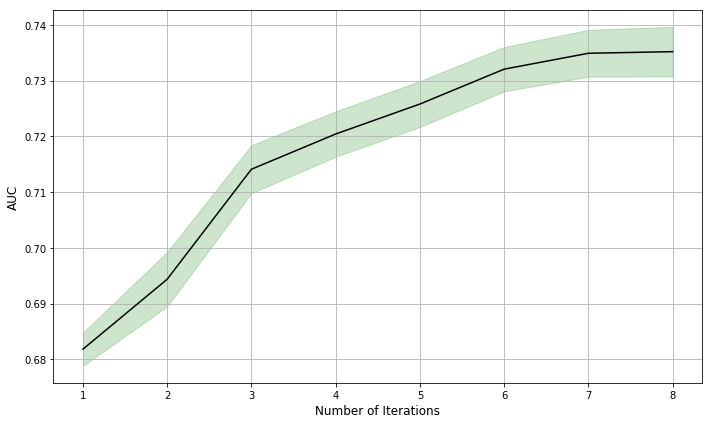

In [22]:
# visualization
mean = np.array(history['auc-mean'])
std = np.array(history['auc-stdv'])
best_rounds = len(mean)
print('Best rounds: ', best_rounds, '\tBest AUC: ', mean[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(mean) + 1), mean, 'k-')
ax.fill_between(range(1, len(mean) + 1), mean-std, mean+std, alpha=0.2, color='g')
ax.set_xlabel('Number of Iterations', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

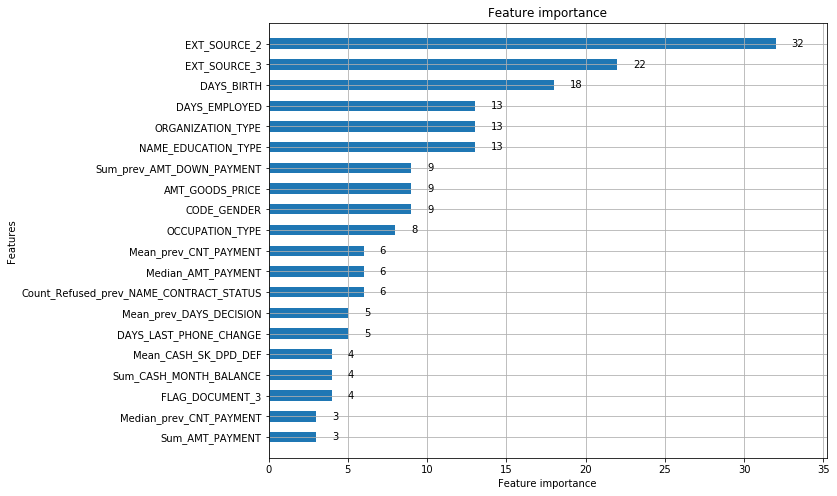

In [23]:
# re-train the model and make predictions
rf = lgb.train(params, train_set=gbm_train, num_boost_round=best_rounds, 
               feature_name=features, categorical_feature=cat_feature)
rf_test_pred = rf.predict(test)

# feature importance
features = rf.feature_name()
importance = rf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(rf, ax=ax, height=0.5, max_num_features=20)
plt.show()

In [24]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = rf_test_pred

rf_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                       columns=['SK_ID_CURR', 'TARGET'])
rf_csv.to_csv('./result/random_forest_balanced.csv', index=False)

# LightGBM Boosting

In [15]:
# Cross validation
params = {'objective': 'binary', 
          'boosting': 'gbdt', 
          'learning_rate': 0.1, 
          'num_leaves': 31, 
          'num_threads': 4, 
          'max_depth': -1, 
          'min_data_in_leaf': 20, 
          'bagging_fraction': 1.0, 
          'bagging_freq': 0, 
          'feature_fraction': 1.0, 
          'lambda_l1': 0.0,
          'lambda_l2': 0.0,
          'drop_rate': 0.1, 
          'is_unbalance': True, 
          'metric': ['auc']}

# 5-folder cross validation
history = lgb.cv(params, train_set=gbm_train, num_boost_round=1000, nfold=5, 
                 stratified=True, early_stopping_rounds=50, verbose_eval=False, 
                 seed=42, feature_name=features, categorical_feature=cat_feature)

Best rounds:  997 	Best AUC:  0.768452516202


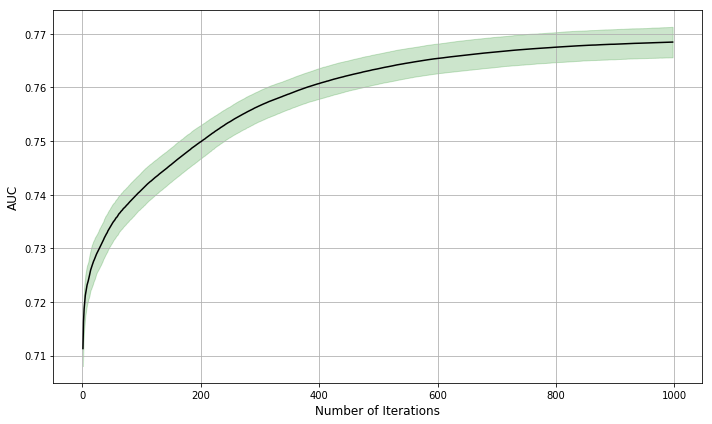

In [16]:
# visualization
mean = np.array(history['auc-mean'])
std = np.array(history['auc-stdv'])
best_rounds = len(mean)
print('Best rounds: ', best_rounds, '\tBest AUC: ', mean[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(mean) + 1), mean, 'k-')
ax.fill_between(range(1, len(mean) + 1), mean-std, mean+std, alpha=0.2, color='g')
ax.set_xlabel('Number of Iterations', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

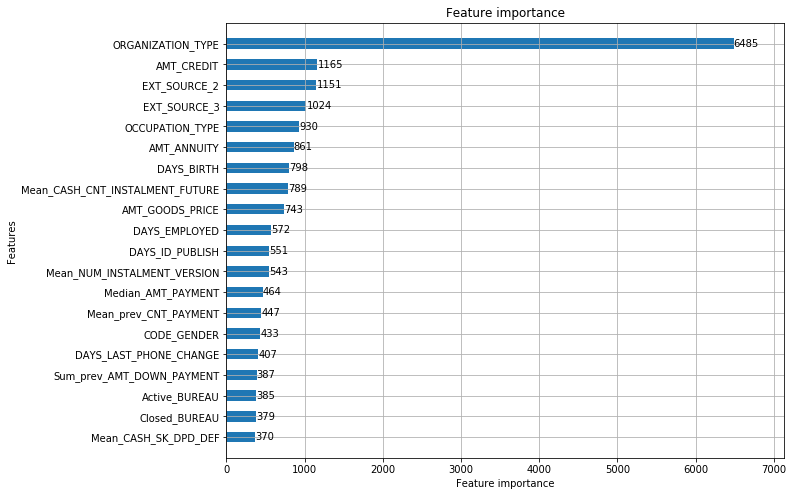

In [17]:
# re-train the model and make predictions
gbm = lgb.train(params, train_set=gbm_train, num_boost_round=best_rounds, 
                feature_name=features, categorical_feature=cat_feature)
gbm_test_pred = gbm.predict(test)

# feature importance
features = gbm.feature_name()
importance = gbm.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(gbm, ax=ax, height=0.5, max_num_features=20)
plt.show()

In [18]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = gbm_test_pred

gbm_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                       columns=['SK_ID_CURR', 'TARGET'])
gbm_csv.to_csv('./result/lightgbm_boosting_balanced.csv', index=False)